## Introduction
The purpose of this notebook is to explore profiles of human primary T cells post-electroporation. Our main goal is to identify cells that take up the plasmid. Our plasmid is labeled and this allows us to electroporate the plasmid into cells and then profile the label positive cells with regards to their naive/memory and activation status. In the earlier experiment, we profiled the cells one day after electroporation and profiled the ones that are marker positive. In that experiment, we saw that active and memory cells were more likely to be experessing the market that we electroporated and therefore, we now ask whether those cells are more likely to receive the electroporated material.

Similar to the earlier experiment, we used `CD25` (which is expected to be up-regulated upon activation) and also `CD69` (which is an early activation marker). For the naive/memory phenotype, we used the `CCR7/CD45RO` combination where `CCR7+ CD45RO+` cells are assumed to be `naive`, `CCR7+ CD45RO+` cells to be `central memory`, and `CCR7- CD45RO+` ones to be `effective memory`.


## Data preparation
Let's start with importing the frequency table from FlowJo and transforming it to a form that will allow us easily compare different populations.

In [1]:
library('readr')
library('magrittr')
library('dplyr')
library('tidyr')
library('ggplot2')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



We have three donors, two staining strategies, two electroporation conditions, and all cells in their naive state. This is how the original table looks originally:

In [2]:
raw_tbl <-
    read_tsv(
        'flow-data.csv',
        col_types=cols(
            `Sample:`=col_character(),
            `Donor`=col_factor(levels=c('Donor 30', 'Donor 31', 'Donor 33')),
            `Electroporation`=col_factor(levels=c('no DNA', 'NDG plasmid')),
            `Staining`=col_factor(levels=c('Activation status', 'Naive status')),
            .default=col_double()
        )
    )

raw_tbl %>% head

Sample:,Donor,Staining,Electroporation,Live/CCR7+ CD45RO+ | Freq. of Parent,Live/CCR7+ CD45RO- | Freq. of Parent,Live/CCR7- CD45RO+ | Freq. of Parent,Live/CCR7- CD45RO- | Freq. of Parent,Live/CD69+ CD25+ | Freq. of Parent,Live/CD69+ CD25- | Freq. of Parent,⋯,Live/Plasmid+/CD69- CD25- | Freq. of Parent,Live/Plasmid- | Freq. of Parent,Live/Plasmid-/CCR7+ CD45RO+ | Freq. of Parent,Live/Plasmid-/CCR7+ CD45RO- | Freq. of Parent,Live/Plasmid-/CCR7- CD45RO+ | Freq. of Parent,Live/Plasmid-/CCR7- CD45RO- | Freq. of Parent,Live/Plasmid-/CD69+ CD25+ | Freq. of Parent,Live/Plasmid-/CD69+ CD25- | Freq. of Parent,Live/Plasmid-/CD69- CD25+ | Freq. of Parent,Live/Plasmid-/CD69- CD25- | Freq. of Parent
D30-DNA-S1.fcs,Donor 30,Activation status,NDG plasmid,0.63,1.20,12.8,85.40,2.220,12.50000,⋯,78.7,21.3,0.120,0.86,11.20,87.80,0.51000,8.95000,7.06,83.5
D30-DNA-S2.fcs,Donor 30,Naive status,NDG plasmid,35.60,19.70,40.6,4.13,0.028,0.00516,⋯,21.6,21.2,24.600,39.70,31.40,4.33,0.00304,0.00304,50.80,49.2
D30-NODNA-S1.fcs,Donor 30,Activation status,no DNA,0.60,1.48,11.6,86.30,1.840,13.60000,⋯,0.0,100.0,0.600,1.48,11.60,86.30,1.84000,13.60000,5.41,79.1
D30-NODNA-S2.fcs,Donor 30,Naive status,no DNA,36.40,19.00,40.3,4.29,0.027,0.00423,⋯,75.0,100.0,36.400,19.00,40.30,4.29,0.02700,0.00362,73.10,26.8
D31-DNA-S1.fcs,Donor 31,Activation status,NDG plasmid,0.67,1.23,10.0,88.10,2.420,17.80000,⋯,72.9,20.7,0.023,0.56,6.72,92.70,0.32000,11.90000,4.75,83.1
D31-DNA-S2.fcs,Donor 31,Naive status,NDG plasmid,26.70,33.90,30.6,8.81,0.019,0.00736,⋯,41.4,20.3,14.600,53.30,20.20,11.90,0.00000,0.00000,29.30,70.7


We want to transform it so that each observation per population becomes a row:

In [3]:
flow_data <-
    raw_tbl %>%
    gather(
        key='Population',
        value='Freq_of_Parent',
        factor_key=TRUE,
        `Live/CCR7+ CD45RO+ | Freq. of Parent`:`Live/Plasmid-/CD69- CD25- | Freq. of Parent`
    )

flow_data %>% head

Sample:,Donor,Staining,Electroporation,Population,Freq_of_Parent
D30-DNA-S1.fcs,Donor 30,Activation status,NDG plasmid,Live/CCR7+ CD45RO+ | Freq. of Parent,0.63
D30-DNA-S2.fcs,Donor 30,Naive status,NDG plasmid,Live/CCR7+ CD45RO+ | Freq. of Parent,35.60
D30-NODNA-S1.fcs,Donor 30,Activation status,no DNA,Live/CCR7+ CD45RO+ | Freq. of Parent,0.60
D30-NODNA-S2.fcs,Donor 30,Naive status,no DNA,Live/CCR7+ CD45RO+ | Freq. of Parent,36.40
D31-DNA-S1.fcs,Donor 31,Activation status,NDG plasmid,Live/CCR7+ CD45RO+ | Freq. of Parent,0.67
D31-DNA-S2.fcs,Donor 31,Naive status,NDG plasmid,Live/CCR7+ CD45RO+ | Freq. of Parent,26.70


## Plasmid positivity
Let's start with checking the electroporation efficiency for each of the conditions. The `no DNA` serves as negative control.

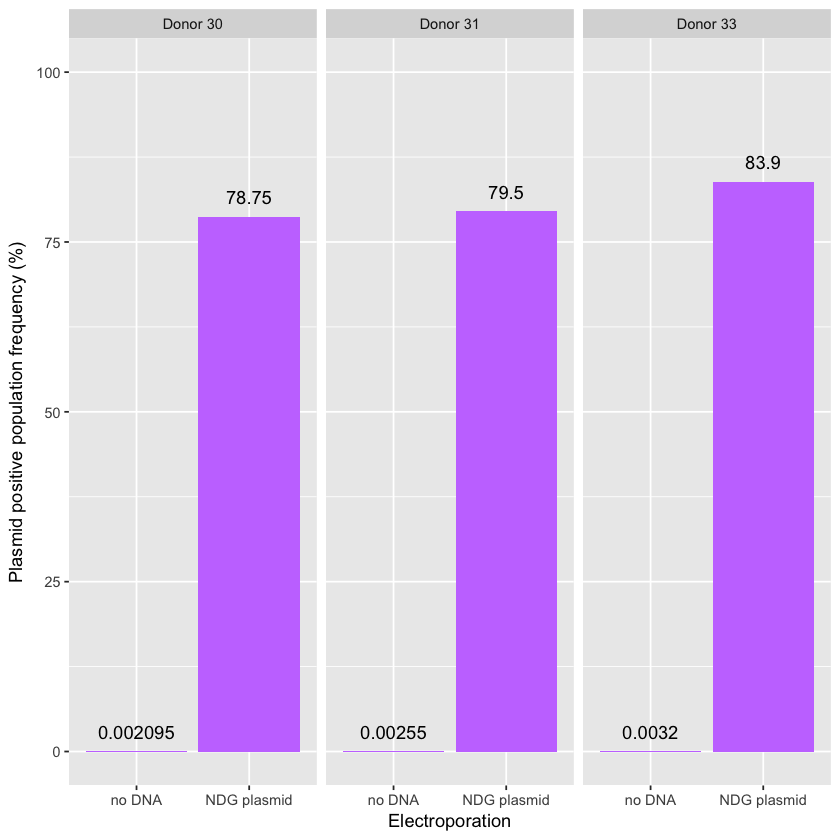

In [4]:
flow_data %>%
    filter(`Population` == 'Live/Plasmid+ | Freq. of Parent') %>%
    group_by(`Donor`, `Electroporation`) %>%
    summarize(
        `Plasmid+`=mean(`Freq_of_Parent`)
    ) %>%
    ggplot(aes(x=`Electroporation`, y=`Plasmid+`)) +
        geom_col(fill="#c77cff") +
        geom_text(aes(label=`Plasmid+`), vjust=-1) +
        facet_wrap(~`Donor`, ncol=3) +
        ylab('Plasmid positive population frequency (%)') +
        ylim(0, 100)

## Overall population comparisons

Looks like the electroporation did work. Before diving into the detailed comparisons, let's compare `no DNA` and `NDG plasmid` conditions and see if their activation and naive/memory statuses are different. Normally, we don't expect any differences across these two conditions but if there is any difference, it would imply that we are probably killing more of one phenotypic population.

### Overall population - activation markers

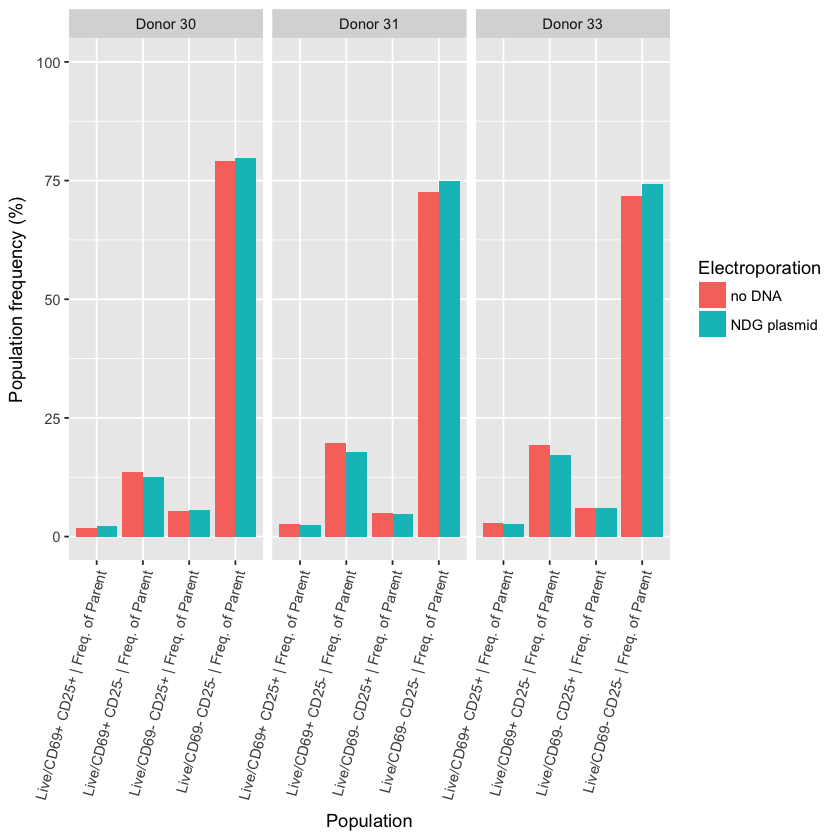

In [5]:
flow_data %>%
    filter(
        `Staining` == 'Activation status',
        `Population` %in% c(
            'Live/CD69+ CD25+ | Freq. of Parent',
            'Live/CD69+ CD25- | Freq. of Parent',
            'Live/CD69- CD25+ | Freq. of Parent',
            'Live/CD69- CD25- | Freq. of Parent'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Electroporation`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=3) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        ylim(0, 100)

There are some differences across populations but we don't see a huge shift in any of the populations. In the activated cells, the plasmid electroporation seem to favor `CD25+ CD69+` cells only a bit and in the unstimulated ones, `CD25- CD69-` cells seem to be relatively more prevalant compared to NDG plasmid.

### Overall population - naive/memory phenotype

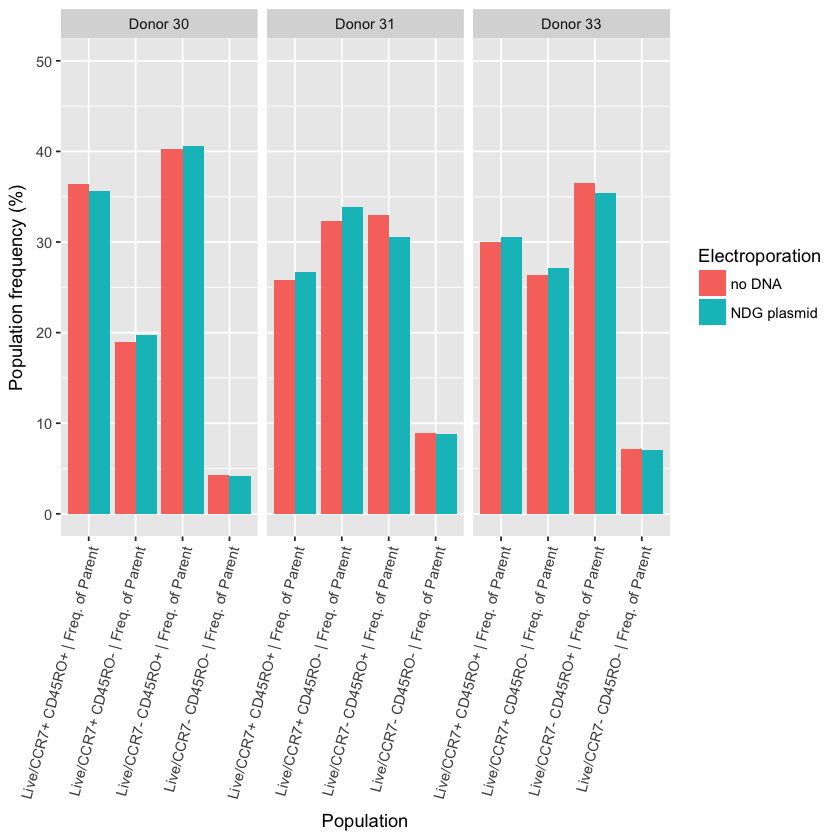

In [6]:
flow_data %>%
    filter(
        `Staining` == 'Naive status',
        `Population` %in% c(
            'Live/CCR7+ CD45RO+ | Freq. of Parent',
            'Live/CCR7- CD45RO+ | Freq. of Parent',
            'Live/CCR7+ CD45RO- | Freq. of Parent',
            'Live/CCR7- CD45RO- | Freq. of Parent'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Electroporation`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=3) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        ylim(0, 50)

## Plasmid positive vs Plasmid negative

After making sure that nothing looks weird with our electroporation and the electroporated populations, let's get the data ready for comparing `Plasmid positive` population to `Plasmid negative` one. The general understanding is that if cells are happily proliferating then they are more likely to take up the material electroporated to them. Let's see if we can uniformly deliver our plasmid into all the cells.

### Data preparation

In [7]:
raw_tbl %>% head

Sample:,Donor,Staining,Electroporation,Live/CCR7+ CD45RO+ | Freq. of Parent,Live/CCR7+ CD45RO- | Freq. of Parent,Live/CCR7- CD45RO+ | Freq. of Parent,Live/CCR7- CD45RO- | Freq. of Parent,Live/CD69+ CD25+ | Freq. of Parent,Live/CD69+ CD25- | Freq. of Parent,⋯,Live/Plasmid+/CD69- CD25- | Freq. of Parent,Live/Plasmid- | Freq. of Parent,Live/Plasmid-/CCR7+ CD45RO+ | Freq. of Parent,Live/Plasmid-/CCR7+ CD45RO- | Freq. of Parent,Live/Plasmid-/CCR7- CD45RO+ | Freq. of Parent,Live/Plasmid-/CCR7- CD45RO- | Freq. of Parent,Live/Plasmid-/CD69+ CD25+ | Freq. of Parent,Live/Plasmid-/CD69+ CD25- | Freq. of Parent,Live/Plasmid-/CD69- CD25+ | Freq. of Parent,Live/Plasmid-/CD69- CD25- | Freq. of Parent
D30-DNA-S1.fcs,Donor 30,Activation status,NDG plasmid,0.63,1.20,12.8,85.40,2.220,12.50000,⋯,78.7,21.3,0.120,0.86,11.20,87.80,0.51000,8.95000,7.06,83.5
D30-DNA-S2.fcs,Donor 30,Naive status,NDG plasmid,35.60,19.70,40.6,4.13,0.028,0.00516,⋯,21.6,21.2,24.600,39.70,31.40,4.33,0.00304,0.00304,50.80,49.2
D30-NODNA-S1.fcs,Donor 30,Activation status,no DNA,0.60,1.48,11.6,86.30,1.840,13.60000,⋯,0.0,100.0,0.600,1.48,11.60,86.30,1.84000,13.60000,5.41,79.1
D30-NODNA-S2.fcs,Donor 30,Naive status,no DNA,36.40,19.00,40.3,4.29,0.027,0.00423,⋯,75.0,100.0,36.400,19.00,40.30,4.29,0.02700,0.00362,73.10,26.8
D31-DNA-S1.fcs,Donor 31,Activation status,NDG plasmid,0.67,1.23,10.0,88.10,2.420,17.80000,⋯,72.9,20.7,0.023,0.56,6.72,92.70,0.32000,11.90000,4.75,83.1
D31-DNA-S2.fcs,Donor 31,Naive status,NDG plasmid,26.70,33.90,30.6,8.81,0.019,0.00736,⋯,41.4,20.3,14.600,53.30,20.20,11.90,0.00000,0.00000,29.30,70.7


In [8]:
plasmid_comp_data <-
    rbind(
        raw_tbl %>%
            select(
                `Donor`:`Electroporation`,
                `Naive: CCR7+ CD45RO-`=`Live/Plasmid+/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/Plasmid+/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/Plasmid+/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/Plasmid+/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/Plasmid+/CD69+ CD25- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/Plasmid+/CD69+ CD25+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/Plasmid+/CD69- CD25+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/Plasmid+/CD69- CD25- | Freq. of Parent`
            ) %>%
            mutate(`Plasmid`="Positive"),
        raw_tbl %>%
            select(
                `Donor`:`Electroporation`,
                `Naive: CCR7+ CD45RO-`=`Live/Plasmid-/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/Plasmid-/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/Plasmid-/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/Plasmid-/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/Plasmid-/CD69+ CD25- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/Plasmid-/CD69+ CD25+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/Plasmid-/CD69- CD25+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/Plasmid-/CD69- CD25- | Freq. of Parent`
            ) %>%
            mutate(`Plasmid`="Negative")
    ) %>%
    mutate(`Plasmid`=as.factor(`Plasmid`)) %>%
    gather(
        key=`Population`,
        value=`Freq_of_Parent`,
        `Naive: CCR7+ CD45RO-`:`CD25- CD69-`
    )

plasmid_comp_data %>% head

Donor,Staining,Electroporation,Plasmid,Population,Freq_of_Parent
Donor 30,Activation status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,1.3
Donor 30,Naive status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,14.4
Donor 30,Activation status,no DNA,Positive,Naive: CCR7+ CD45RO-,33.3
Donor 30,Naive status,no DNA,Positive,Naive: CCR7+ CD45RO-,0.0
Donor 31,Activation status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,1.4
Donor 31,Naive status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,28.9


### Plasmid positive vs negative -- naive status
This time, instead of the `NDG plasmid` and `no DNA` comparison, we will be comparing two different plasmid statuses: `Negative` and `Positive`.

In [9]:
plasmid_comp_data %>% head

Donor,Staining,Electroporation,Plasmid,Population,Freq_of_Parent
Donor 30,Activation status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,1.3
Donor 30,Naive status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,14.4
Donor 30,Activation status,no DNA,Positive,Naive: CCR7+ CD45RO-,33.3
Donor 30,Naive status,no DNA,Positive,Naive: CCR7+ CD45RO-,0.0
Donor 31,Activation status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,1.4
Donor 31,Naive status,NDG plasmid,Positive,Naive: CCR7+ CD45RO-,28.9


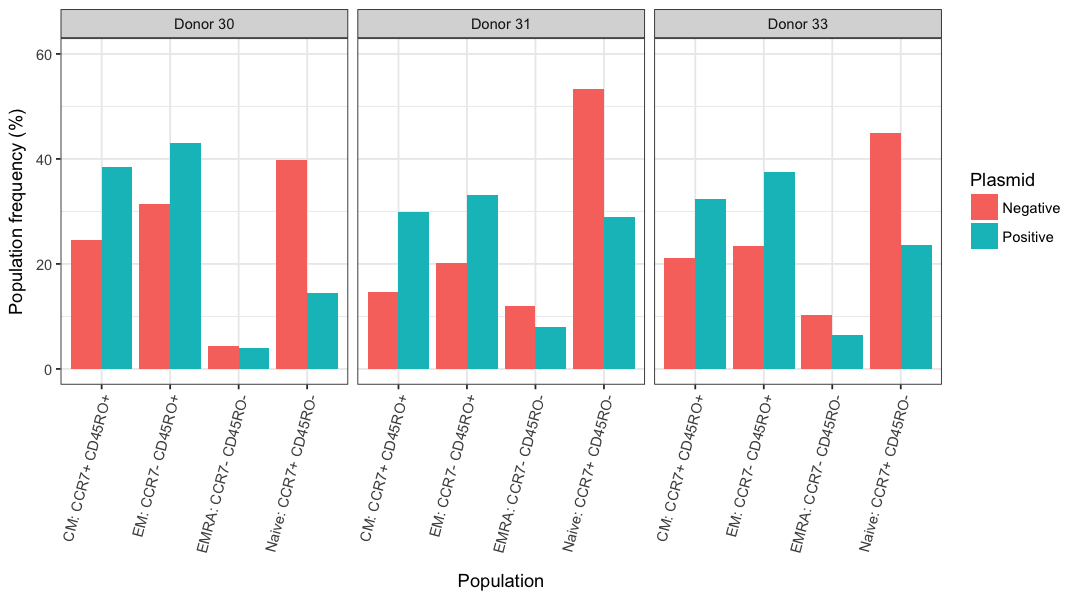

In [16]:
options(repr.plot.width=9, repr.plot.height=5)

plasmid_comp_data %>%
    filter(
        `Staining` == 'Naive status',
        `Electroporation` == 'NDG plasmid',
        `Population` %in% c(
            'CM: CCR7+ CD45RO+',
            'EM: CCR7- CD45RO+',
            'Naive: CCR7+ CD45RO-',
            'EMRA: CCR7- CD45RO-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Plasmid`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=3) +
        ylab('Population frequency (%)') +
        theme_bw() +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        ylim(0, 60)

Looks like memory cells are the ones who are getting the plasmid easier compared to the naive cells. This is interesting as it implies that we are not uniformly delivering our material into all the cells.

### Plasmid positive vs negative -- activation status
Now let's do a similar comparison but this time for their activation status:

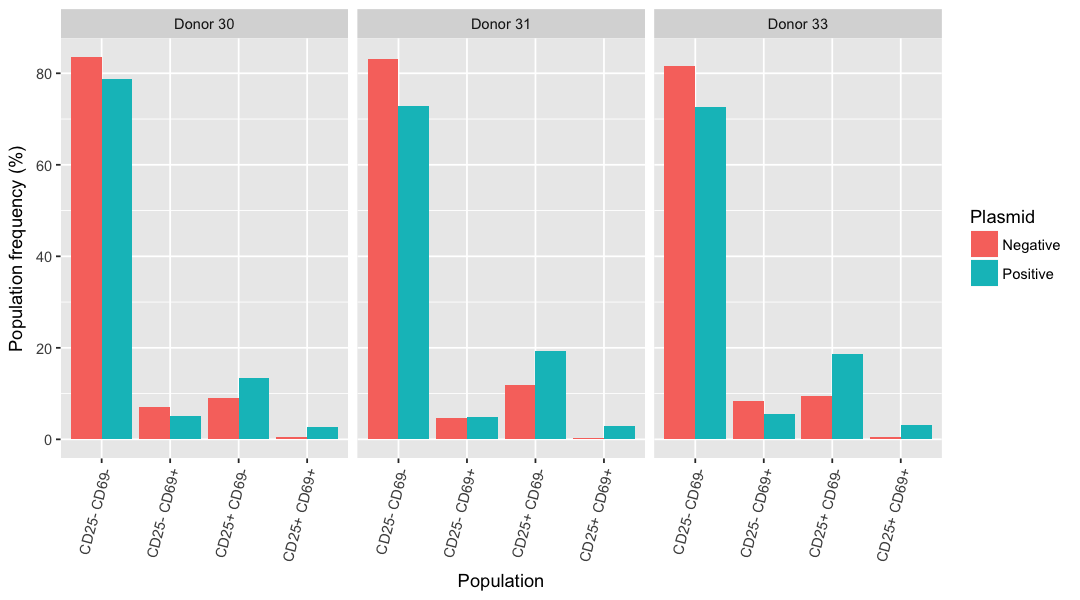

In [11]:
plasmid_comp_data %>%
    filter(
        `Staining` == 'Activation status',
        `Electroporation` == 'NDG plasmid',
        `Population` %in% c(
            'CD25+ CD69+',
            'CD25+ CD69-',
            'CD25- CD69+',
            'CD25- CD69-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Plasmid`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=3) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1))

We see that we are more likely to deliver our plasmid into `CD25+` cells compared to `CD69+` ones.

## Plasmid positive vs population
It was interesting to see major diffences across plasmid positive and negative cells but was that because of the fact that plasmid negative cells are just the minority and hence their composition is subject to more noise. Let's include the parent population in our comparison and see which population deviates from the parent one the most:

In [12]:
population_comp_data <-
    rbind(
        raw_tbl %>%
            select(
                `Donor`:`Electroporation`,
                `Naive: CCR7+ CD45RO-`=`Live/Plasmid-/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/Plasmid-/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/Plasmid-/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/Plasmid-/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/Plasmid-/CD69+ CD25- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/Plasmid-/CD69+ CD25+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/Plasmid-/CD69- CD25+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/Plasmid-/CD69- CD25- | Freq. of Parent`
            ) %>%
            mutate(`Cells`="Plasmid negative"),
        raw_tbl %>%
            select(
                `Donor`:`Electroporation`,
                `Naive: CCR7+ CD45RO-`=`Live/Plasmid+/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/Plasmid+/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/Plasmid+/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/Plasmid+/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/Plasmid+/CD69+ CD25- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/Plasmid+/CD69+ CD25+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/Plasmid+/CD69- CD25+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/Plasmid+/CD69- CD25- | Freq. of Parent`
            ) %>%
            mutate(`Cells`="Plasmid positive"),
        raw_tbl %>%
            select(
                `Donor`:`Electroporation`,
                `Naive: CCR7+ CD45RO-`=`Live/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/CD69+ CD25- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/CD69+ CD25+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/CD69- CD25+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/CD69- CD25- | Freq. of Parent`
            ) %>%
            mutate(`Cells`="Parent")
    ) %>%
    mutate(`Cells`=factor(`Cells`)) %>%
    gather(
        key=`Population`,
        value=`Freq_of_Parent`,
        `Naive: CCR7+ CD45RO-`:`CD25- CD69-`
    )

population_comp_data %>% head

Donor,Staining,Electroporation,Cells,Population,Freq_of_Parent
Donor 30,Activation status,NDG plasmid,Plasmid negative,Naive: CCR7+ CD45RO-,0.86
Donor 30,Naive status,NDG plasmid,Plasmid negative,Naive: CCR7+ CD45RO-,39.70
Donor 30,Activation status,no DNA,Plasmid negative,Naive: CCR7+ CD45RO-,1.48
Donor 30,Naive status,no DNA,Plasmid negative,Naive: CCR7+ CD45RO-,19.00
Donor 31,Activation status,NDG plasmid,Plasmid negative,Naive: CCR7+ CD45RO-,0.56
Donor 31,Naive status,NDG plasmid,Plasmid negative,Naive: CCR7+ CD45RO-,53.30


## Parent, plasmid positive, and plasmid negative populations -- activation status

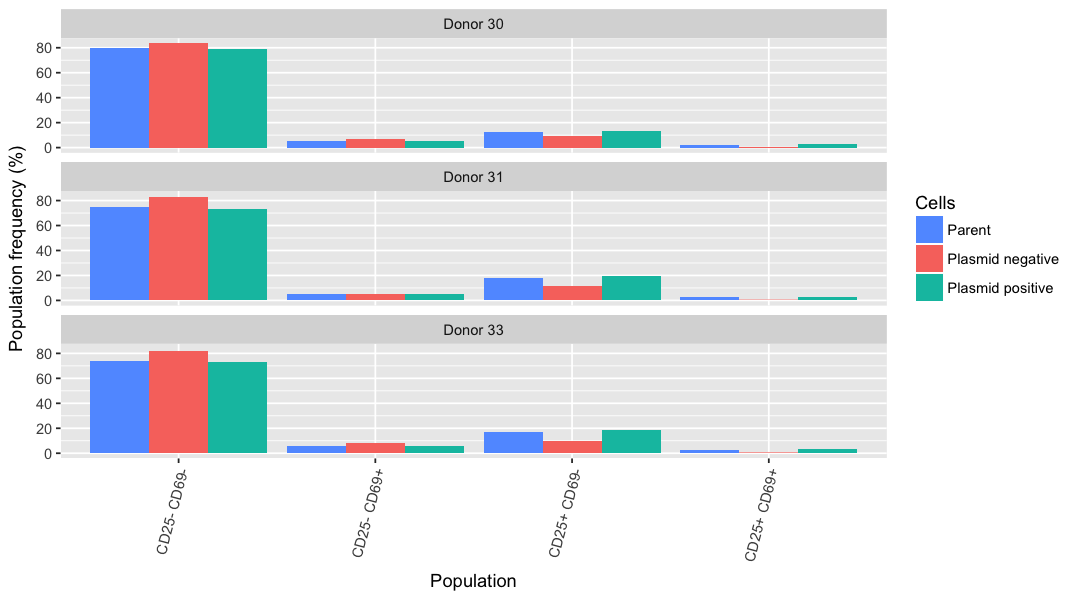

In [13]:
population_comp_data %>%
    filter(
        `Staining` == 'Activation status',
        `Electroporation` == 'NDG plasmid',
        `Population` %in% c(
            'CD25+ CD69+',
            'CD25+ CD69-',
            'CD25- CD69+',
            'CD25- CD69-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Cells`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=1) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        scale_fill_manual(values=c("#619cff", "#f8766d", "#00c0af"))

## Parent, plasmid positive, and plasmid negative populations -- naive status

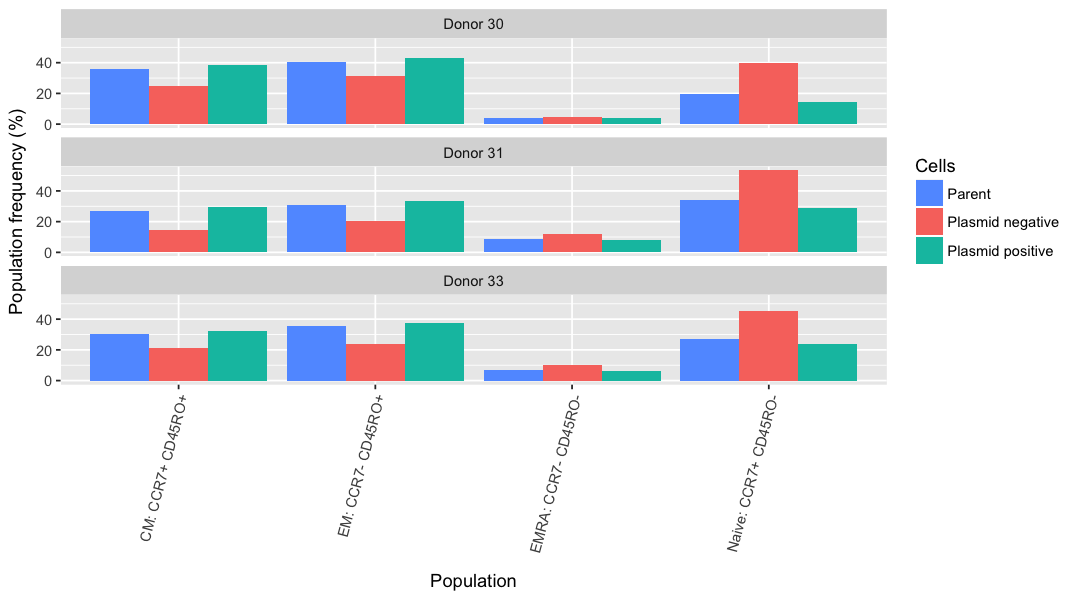

In [14]:
population_comp_data %>%
    filter(
        `Staining` == 'Naive status',
        `Electroporation` == 'NDG plasmid',
        `Population` %in% c(
            'CM: CCR7+ CD45RO+',
            'EM: CCR7- CD45RO+',
            'Naive: CCR7+ CD45RO-',
            'EMRA: CCR7- CD45RO-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Cells`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`, ncol=1) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        scale_fill_manual(values=c("#619cff", "#f8766d", "#00c0af"))

So the phenotypic prevalances for the plasmid positive population is more similar to the parent population compared the plasmid negative ones.